# <center> IoT Device on Bicycle Safety: a case study with an unsupervised clustering model to estimate hazardous areas </center>

<center> MSc Analysis </center>
<center> Universidade de Brasília (PPGT/UnB) </center>

<center>MSc Candidate: <a href="https://www.linkedin.com/in/marcelmello/" target="_blank"> LinkedIn </a></center>
<center> Curriculum: <a href="" target="_blank"> Lattes </a></center>

This research aimed to estimate hazardous areas for bicycle mobility by comparing unsupervised machine-learning algorithms based on an Internet of Things sensor device for data collection. The Lateral Passing Distance (LPD) data collected among bicycles and vehicles were related to a variate cyclist data. Some of this data includes bicycle velocity, curse elevation, global positioning system (GPS) coordinates, acceleration, and gyroscopic information through a naturalistic collection on the street.

In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

#Python Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score as ss
from scipy import stats
import scipy.stats as stats

import geopandas as gpd
import contextily #mapas estaticos
import folium #mapas dinâmicos(html)
from shapely.geometry import Point

print('Python dependencies installed')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 34.5 MB/s eta 0:00:00
Python dependencies installed


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/MSc/park_analysis4_total.xlsx")
  #csv dando problema de encode

# Exploratory Data Analysis

In [ ]:
df.head(3)

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd_left,speed
0,-15.804338,-47.910262,2.810793,0.689530,2.487576,0.195,49.954198,0.290076,-14.366412,189.04,9.062
1,-15.797828,-47.911870,-0.062249,6.449979,19.612701,0.190,55.763359,7.351145,-10.389313,160.03,6.722
2,-15.808282,-47.926879,0.423774,8.176199,-5.906495,0.147,-8.717557,-1.816794,-10.396947,65.30,3.850


In [ ]:
exploratory = df.copy()
exploratory.rename(columns = {' us_lpd_left':'lpd'}, inplace = True)
exp = exploratory[exploratory['lpd'] >= 5]

#adjusting column name and apply the 5cm for the width error

Lateral Passing Distance Statistics

In [ ]:
exp['lpd'].describe()

count    160.000000
mean     261.129563
std      154.532185
min       35.630000
25%      139.615000
50%      238.780000
75%      351.080000
max      693.170000
Name: lpd, dtype: float64

Lateral Passing Distance Histogram with Kernel Density Estimation (KDE)

Text(0.5, 0, 'Lateral Passing Distance (cm)')

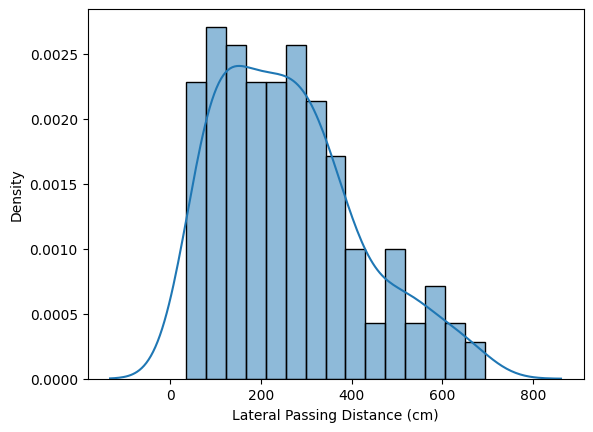

In [ ]:
expkde = sns.histplot(exp['lpd'],kde=True, stat="density", kde_kws=dict(cut=3), bins=15)
expkde.set_xlabel("Lateral Passing Distance (cm)")

Text(0.5, 0, 'Speed (m/s)')

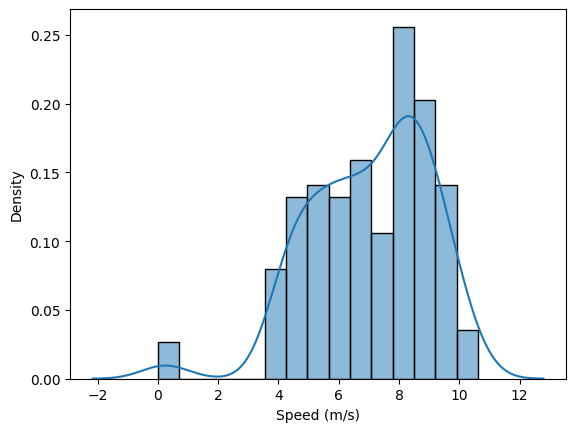

In [ ]:
expkde2 = sns.histplot(exp['speed'], kde=True, stat="density", kde_kws=dict(cut=3), bins=15)
expkde2.set_xlabel("Speed (m/s)")

Relationship between Climb and LPD

In [ ]:
exp_climb_lpd = px.scatter(exp, x='lpd',y='climb', color='lpd')
exp_climb_lpd

Percentage of values in ascending and downward movement regarding the threshold lateral clearance distance of 150cm.
(LPD < 150cm uphill)

In [ ]:
up = exp[(exp['climb'] > 0) & (exp['lpd'] < 150)].value_counts('lpd')
down = exp[(exp['climb'] < 0) & (exp['lpd'] < 150)].value_counts('lpd')

p = up.count()/down.count()
(p-1)*100

4.347826086956519

When relating LPD to Climb and Speed, the following correlation was obtained by fitting a regression model to observe the resulting line on a 95% confidence interval. The LPD is on the y-axis, and the climb and speed data are on the x-axis.

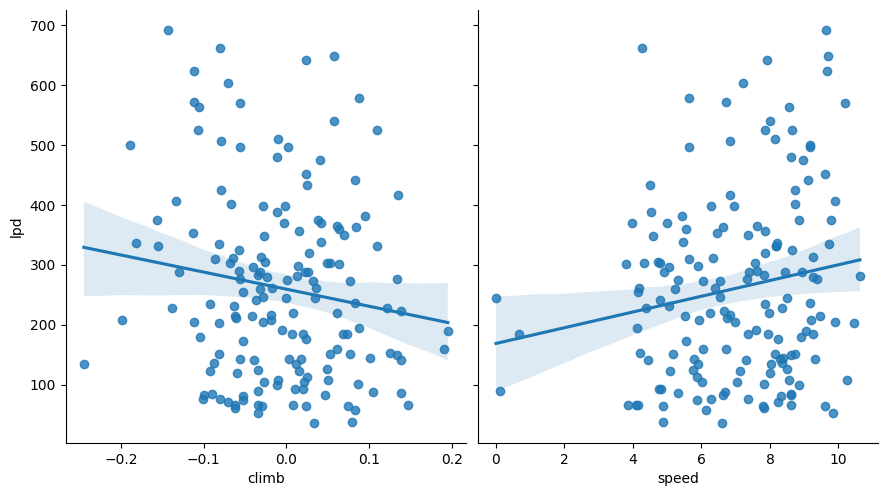

In [ ]:
sns.pairplot(exp, x_vars=["climb", "speed"], y_vars=["lpd"], height=5, aspect=.9, kind="reg");

Acceleration and Rotation correlation to LPD, fitting a regression model to observe the resulting line on a 95% confidence interval.

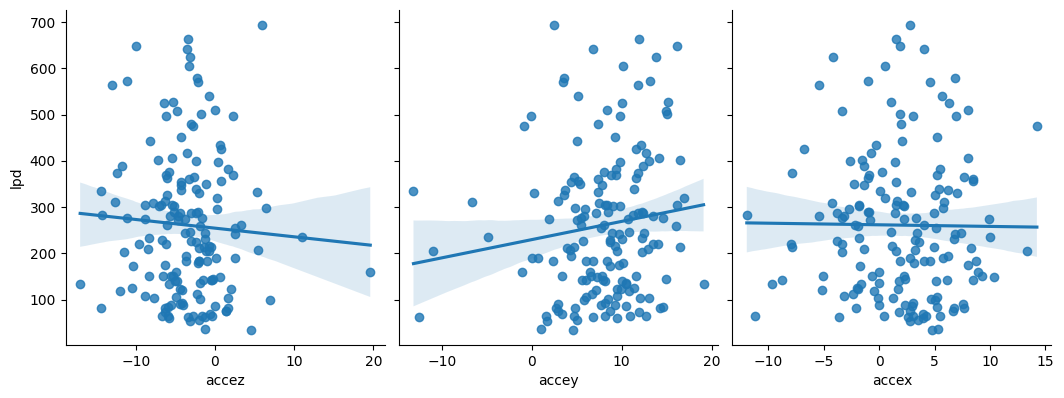

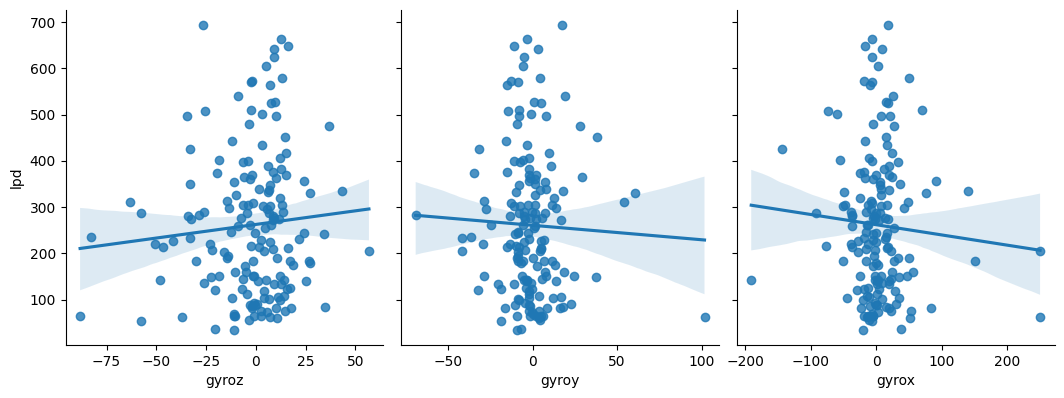

In [ ]:
sns.pairplot(exp, x_vars=["accez",'accey',"accex"], y_vars=["lpd"], height=4, aspect=.9, kind="reg");
sns.pairplot(exp, x_vars=["gyroz",'gyroy',"gyrox"], y_vars=["lpd"], height=4, aspect=.9, kind="reg");

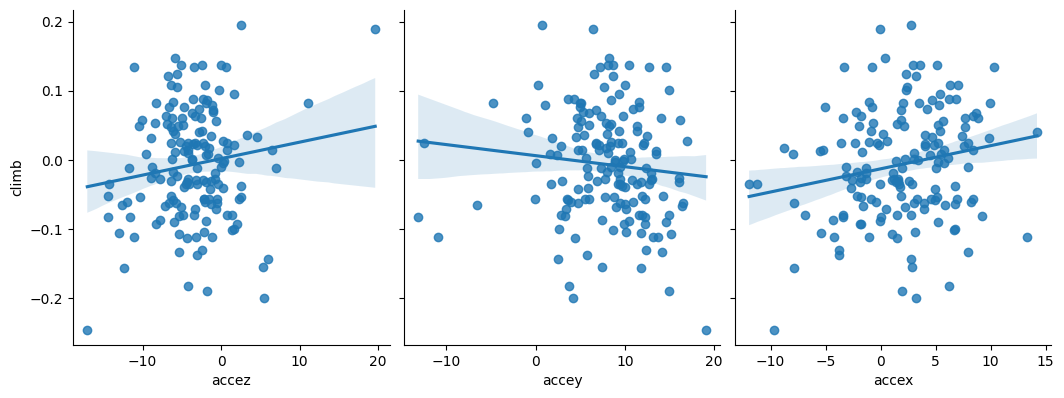

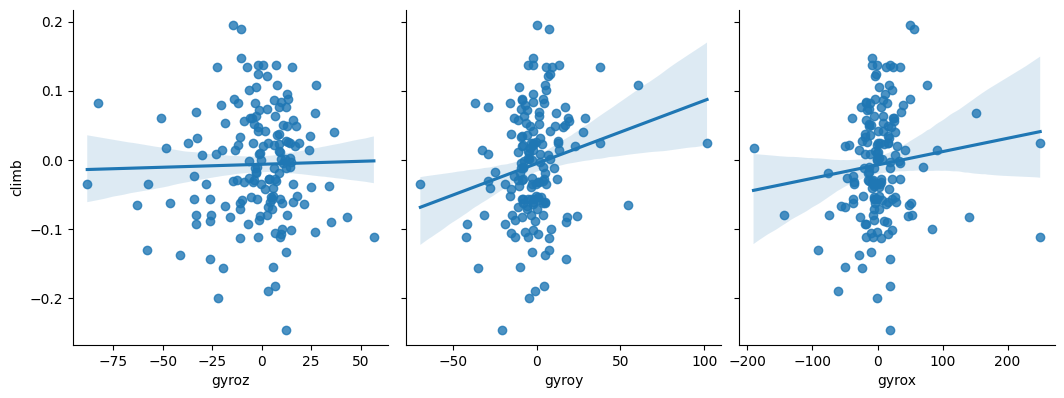

In [ ]:
sns.pairplot(exp, x_vars=["accez",'accey',"accex"], y_vars=["climb"], height=4, aspect=.9, kind="reg");
sns.pairplot(exp, x_vars=["gyroz",'gyroy',"gyrox"], y_vars=["climb"], height=4, aspect=.9, kind="reg");


#Accident history - Geo Pandas

In [ ]:
import pandas as pd
geo = pd.read_excel('/content/drive/MyDrive/MSc/sinistrosbike_pdc.xlsx')

In [ ]:
geo.head(3)

,fid,Fatalidade,Data,Dia,Jurisdicao,RA,Via-Av.,Endereco,Natureza,Vit. Falta,Vit. Ferido,Veiculo,Ano,latitude,longitude
0,3632,NÃO,2019-07-17,4-QUA,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, PRÓX. AO ESTACIONAMEN...",COLISÃO,-,1,CAMINHONETA x BICICLETA,2019,-15.792456,-47.896588
1,3990,NÃO,2019-07-16,3-TER,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, SRPS, PRÓX. AO PAVILH...",COLISÃO,-,1,BICICLETA x AUTOMÓVEL,2019,-15.795415,-47.910087
2,5129,NÃO,2017-10-03,3-TER,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, PRÓX. AO ESTACIONAMEN...",COLISÃO,-,1,CAMINHONETA x BICICLETA,2017,-15.803819,-47.905642


In [ ]:
import geopandas as gpd
geometry = [Point(xy) for xy in zip(geo['longitude'], geo['latitude'])]
geo_pdc = gpd.GeoDataFrame(geo, crs='EPSG:4326', geometry=geometry)

  #crio uma coluna com pontos de longitude e latidude agrupados.
  #tranformo o df em GeoDataFrame
  #ajusto o sistema de coordenadas geo - EPSG:4326

#geo_pdc = geo_pdc.to_crs(crs='EPSG:3857')
#geo_pdc.crs.to_string()

  #altero o sis de coordenadas geo para EPSG:3857 (trabalha em metros)
  #confere crs

In [ ]:
geo_pdc.head()

,fid,Fatalidade,Data,Dia,Jurisdicao,RA,Via-Av.,Endereco,Natureza,Vit. Falta,Vit. Ferido,Veiculo,Ano,latitude,longitude,geometry
0,3632,NÃO,2019-07-17,4-QUA,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, PRÓX. AO ESTACIONAMEN...",COLISÃO,-,1,CAMINHONETA x BICICLETA,2019,-15.792456,-47.896588,POINT (-47.89659 -15.79246)
1,3990,NÃO,2019-07-16,3-TER,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, SRPS, PRÓX. AO PAVILH...",COLISÃO,-,1,BICICLETA x AUTOMÓVEL,2019,-15.795415,-47.910087,POINT (-47.91009 -15.79542)
2,5129,NÃO,2017-10-03,3-TER,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, PRÓX. AO ESTACIONAMEN...",COLISÃO,-,1,CAMINHONETA x BICICLETA,2017,-15.803819,-47.905642,POINT (-47.90564 -15.80382)
3,5189,NÃO,2018-08-07,3-TER,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, PRÓX. AO GIBÃO",COLISÃO,-,1,BICICLETA x CAMINHONETA,2018,-15.804182,-47.920026,POINT (-47.92003 -15.80418)
4,5451,NÃO,2018-12-16,1-DOM,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, PRÓX. AO ALPINOS",COLISÃO,-,1,CAMINHONETA x BICICLETA,2018,-15.806083,-47.924813,POINT (-47.92481 -15.80608)


In [ ]:
geo_pdc = geo_pdc.to_crs(crs='EPSG:3857')
  #altero o sis de coordenadas geo para EPSG:3857 (trabalha em metros)

In [ ]:
geo_pdc.crs.to_string()

'EPSG:3857'

Crashes visualization

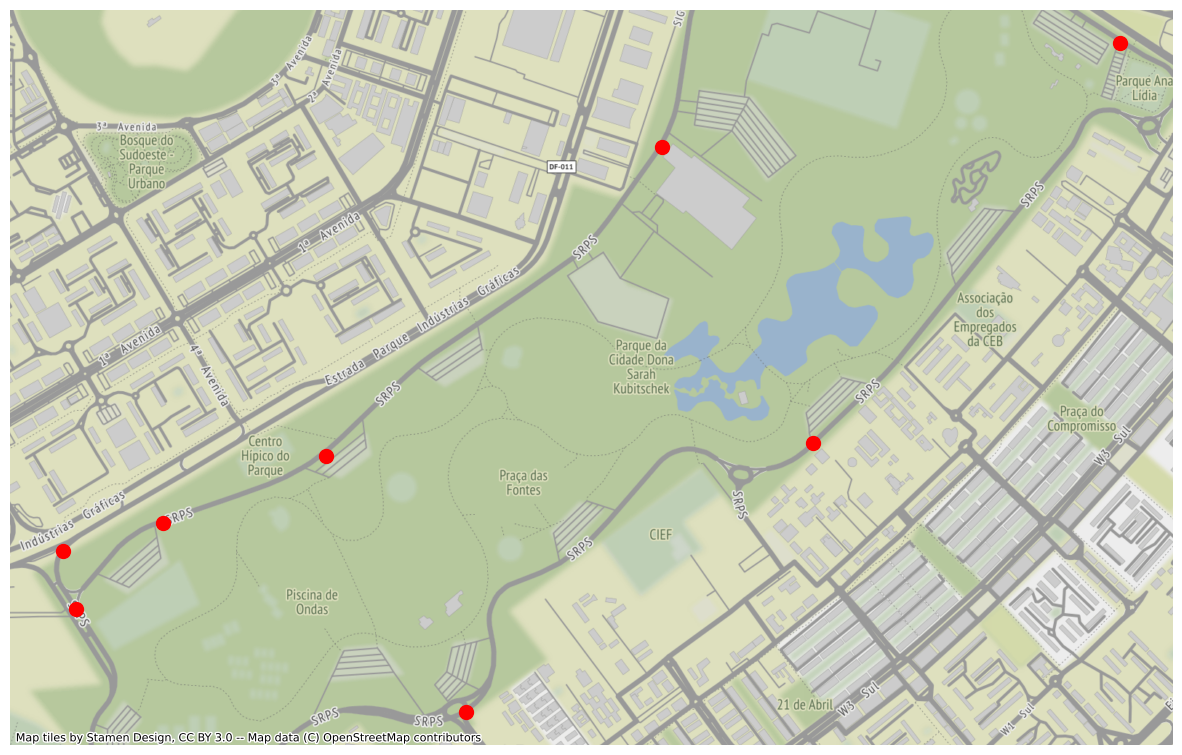

In [ ]:
import matplotlib.pyplot as plt
ax = geo_pdc.plot(figsize=(15, 22), markersize=100, color='red', legend=True)
contextily.add_basemap(ax) #biblioteca que dá um contexto pro mapa (um fundo)
ax.set_axis_off()
plt.show()

In [ ]:
pdc_folium = geo_pdc.copy()
accidents = pdc_folium[['latitude', 'longitude']]
locationlist = accidents.values.tolist()
len(locationlist)
locationlist[0]

[-15.792456, -47.896588]

In [ ]:
pdc_folium = pdc_folium.reset_index()

Crases visualization - Interative map

In [ ]:
park_center = [-15.804051955,	-47.90995495]
mapa = folium.Map(location=park_center, zoom_start=14)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point],
                  popup=pdc_folium['Veiculo'][point],
                  icon=folium.Icon(color='red')).add_to(mapa)

#mapa.save('accidents_pdc.html')

mapa

#K-means - Andy




In [ ]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 160
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   160 non-null    float64
 1   longitude  160 non-null    float64
 2   accex      160 non-null    float64
 3   accey      160 non-null    float64
 4   accez      160 non-null    float64
 5   climb      160 non-null    float64
 6   gyrox      160 non-null    float64
 7   gyroy      160 non-null    float64
 8   gyroz      160 non-null    float64
 9   lpd        160 non-null    float64
 10  speed      160 non-null    float64
dtypes: float64(11)
memory usage: 15.0 KB


In [ ]:
pck = exp.copy()
pck.rename(columns = {'lpd':'us_lpd'}, inplace = True)

In [ ]:
pck.head(2)

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,speed
0,-15.804338,-47.910262,2.810793,0.689530,2.487576,0.195,49.954198,0.290076,-14.366412,189.04,9.062
1,-15.797828,-47.911870,-0.062249,6.449979,19.612701,0.190,55.763359,7.351145,-10.389313,160.03,6.722


In [ ]:
def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)

 #Generating the
    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.title('Elbow Method For Optimal number of Clusters')
    plt.grid(True)
    plt.show()

In [ ]:
scaler = StandardScaler()
# scaler = StandaMinMaxScaler() quando der erro de que os valores são de grandezas diferente'
# pck[['climb_t', 'us_lpd_t', 'speed_t']] = scaler.fit_transform(pck[['climb', 'us_lpd', 'speed']])
pck[['climb_t', 'us_lpd_t', 'speed_t',
     'accex_t', 'accey_t', 'accez_t',
     'gyrox_t', 'gyroy_t', 'gyroz_t']] = scaler.fit_transform(pck[['climb', 'us_lpd', 'speed',
                                                                   'accex', 'accey', 'accez',
                                                                   'gyrox', 'gyroy', 'gyroz']])
pck.head()

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,speed,climb_t,us_lpd_t,speed_t,accex_t,accey_t,accez_t,gyrox_t,gyroy_t,gyroz_t
0,-15.804338,-47.910262,2.810793,0.689530,2.487576,0.195,49.954198,0.290076,-14.366412,189.04,9.062,2.529080,-0.467967,1.022009,0.193587,-1.403359,1.246864,0.983415,0.090335,-0.557588
1,-15.797828,-47.911870,-0.062249,6.449979,19.612701,0.190,55.763359,7.351145,-10.389313,160.03,6.722,2.466283,-0.656284,-0.156858,-0.424234,-0.291584,4.809037,1.107826,0.490120,-0.370812
2,-15.808282,-47.926879,0.423774,8.176199,-5.906495,0.147,-8.717557,-1.816794,-10.396947,65.30,3.850,1.926227,-1.271220,-1.603740,-0.319720,0.041579,-0.499175,-0.273117,-0.028952,-0.371171
3,-15.791270,-47.909070,5.164293,8.135497,-5.066131,0.138,19.106870,13.541985,0.824427,140.94,4.424,1.813192,-0.780206,-1.314565,0.699686,0.033724,-0.324372,0.322779,0.840635,0.155818
4,-15.799999,-47.914681,3.617639,8.690952,-2.391807,0.138,-0.664122,-5.297710,7.038168,223.68,6.653,1.813192,-0.243102,-0.191619,0.367092,0.140927,0.231911,-0.100642,-0.226035,0.447633


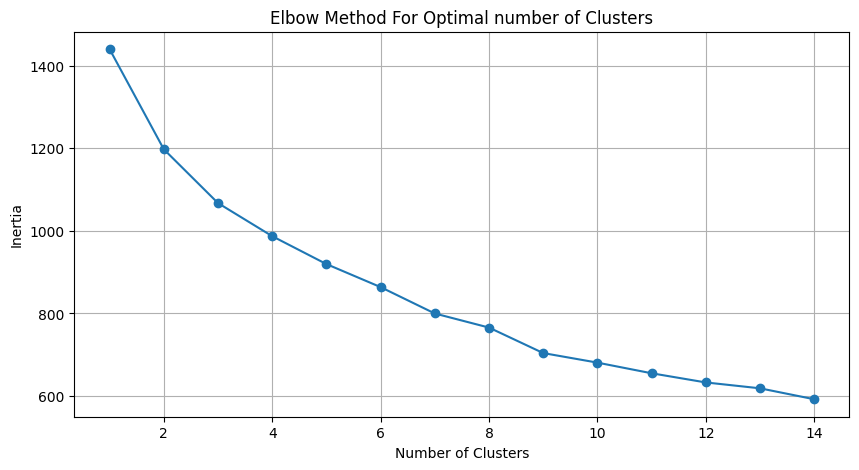

In [ ]:
# optimise_k_means(pck[['us_lpd_t', 'speed_t']], 15)
optimise_k_means(pck[['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t']], 15)
# #plt.axvline(3, linestyle='--', color='r') = ver no notebok Bike itau

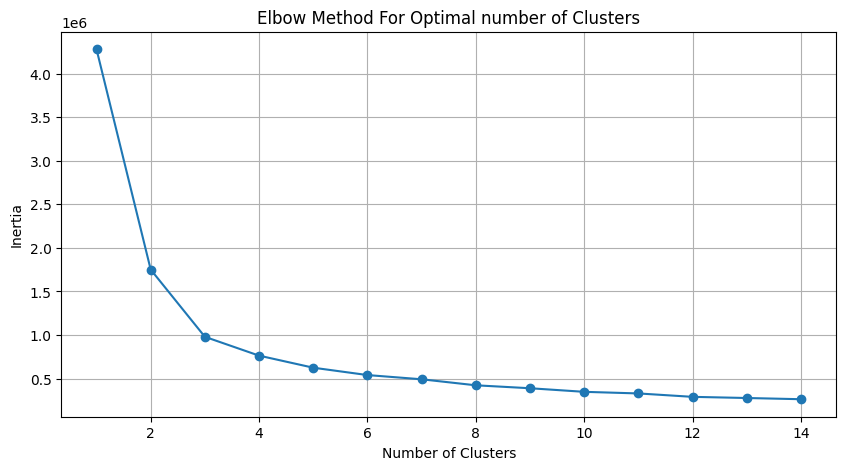

In [ ]:
optimise_k_means(pck[['accex', 'accey', 'accez', 'gyrox', 'gyroy', 'gyroz', 'climb', 'us_lpd', 'speed']], 15)
# optimise_k_means(pck[['climb', 'us_lpd', 'speed']], 15)

In the plot above, we can see that the inertia (sum of the squared distances to the nearest cluster center) decreases as we increase the number of clusters. There is no clear defined break within this dataset, however, we can see that the slope changes from about 4 (3 to 5) clusters onwards.

In [ ]:
# random_state=10 - forma como estava

from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
silscore = []
X2 = pck[['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t']].copy()

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++', n_init=42)
    cluster_labels = clusterer.fit_predict(X2)
    silhouette_avg = silhouette_score(X2, cluster_labels)
    silscore.append(silhouette_avg)
    print("For n_clusters =", n_clusters,",","The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X2, cluster_labels)

For n_clusters = 2 , The average silhouette_score is : 0.1494376080559297
For n_clusters = 3 , The average silhouette_score is : 0.1423422950395586
For n_clusters = 4 , The average silhouette_score is : 0.11203048620299368
For n_clusters = 5 , The average silhouette_score is : 0.11724003299528282
For n_clusters = 6 , The average silhouette_score is : 0.12300094529526032
For n_clusters = 7 , The average silhouette_score is : 0.11185805454526856
For n_clusters = 8 , The average silhouette_score is : 0.1318971247526764
For n_clusters = 9 , The average silhouette_score is : 0.12897324805535634
For n_clusters = 10 , The average silhouette_score is : 0.11689751025290088
For n_clusters = 15 , The average silhouette_score is : 0.11491377206212161


Fititting the clustering models

In [ ]:
# kmeans = KMeans(n_clusters=2)
# kmeans.fit(pck[['accex_t', 'accey_t', 'accez_T', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'climb_t', 'us_lpd_t', 'speed_t']])
# #X['cluster_label'] = kmeans.fit_predict(X)
# #centers = kmeans.cluster_centers_
# #labels = kmeans.predict(df[['Latitude', 'Longitude', 'Usreading R']])

# kmeans.cluster_centers_

In [ ]:
# centers = kmeans.cluster_centers_
# centers

Running K-means clustering algorithm, the initial cluster centroids are randomly initialized, which means that each run it get different results. A random seed was set for the K-means algorithm to ensure reproducible results. This ensures that the initial cluster centroids are initialized in the same way every time the algorithm is used with the same seed value.

In [ ]:
for k in range(2,7):
  kmeans=KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=42)
  kmeans.fit(pck[['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t']])
  pck[f'KMeans_{k}'] = kmeans.labels_

In [ ]:
pck.head()

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,...,accey_t,accez_t,gyrox_t,gyroy_t,gyroz_t,KMeans_2,KMeans_3,KMeans_4,KMeans_5,KMeans_6
0,-15.804338,-47.910262,2.810793,0.689530,2.487576,0.195,49.954198,0.290076,-14.366412,189.04,...,-1.403359,1.246864,0.983415,0.090335,-0.557588,1,0,0,3,4
1,-15.797828,-47.911870,-0.062249,6.449979,19.612701,0.190,55.763359,7.351145,-10.389313,160.03,...,-0.291584,4.809037,1.107826,0.490120,-0.370812,1,0,0,3,2
2,-15.808282,-47.926879,0.423774,8.176199,-5.906495,0.147,-8.717557,-1.816794,-10.396947,65.30,...,0.041579,-0.499175,-0.273117,-0.028952,-0.371171,1,2,1,1,1
3,-15.791270,-47.909070,5.164293,8.135497,-5.066131,0.138,19.106870,13.541985,0.824427,140.94,...,0.033724,-0.324372,0.322779,0.840635,0.155818,1,2,1,3,1
4,-15.799999,-47.914681,3.617639,8.690952,-2.391807,0.138,-0.664122,-5.297710,7.038168,223.68,...,0.140927,0.231911,-0.100642,-0.226035,0.447633,1,2,1,3,1


## K-means Cluster Representation

In [ ]:
#plotly
# pck["KMeans_3"] = pck["KMeans_3"].astype(float) #convert to string
figkmeans = px.scatter(y=pck['latitude'],
                       x=pck['longitude'],
                       size=pck['us_lpd'],
                       color=pck['KMeans_3'],
                       color_continuous_scale=[(0.00, "blue"),
                                               (0.33, "blue"),
                                               (0.33, "orange"),
                                               (0.66, "orange"),
                                               (0.66, "red"),
                                               (1.00, "red")], size_max=25)

figkmeans.update_layout(title={'text':'K-Means Cluster Analysis',
                               'y':0.95,
                               'x':0.5,
                               'xanchor': 'center',
                               'yanchor': 'top'},
                         xaxis_title="Longitude",
                         yaxis_title="Latitude")

# contextily.add_basemap(ax)
# # fignew.set_axis_off()
figkmeans.show()

In [ ]:
pck_k0 = pck[pck['KMeans_3'] == 0].drop(columns=['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'KMeans_2', 'KMeans_4', 'KMeans_5', 'KMeans_6'])
pck_k1 = pck[pck['KMeans_3'] == 1].drop(columns=['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'KMeans_2', 'KMeans_4', 'KMeans_5', 'KMeans_6'])
pck_k2 = pck[pck['KMeans_3'] == 2].drop(columns=['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'KMeans_2', 'KMeans_4', 'KMeans_5', 'KMeans_6'])

In [ ]:
fignew0 = px.scatter(y=pck_k0['latitude'],
                    x=pck_k0['longitude'],
                    size=pck_k0['us_lpd'],
                    color=pck_k0['KMeans_3'],
                    color_continuous_scale=[(0.00, "blue"),
                                            (1.00, "blue")], size_max=30)

fignew0.update_layout(title={'text':'Cluster Analysis',
                            'y':0.95,
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'},
                    xaxis_title="Longitude",
                    yaxis_title="Latitude")
fignew0.show()

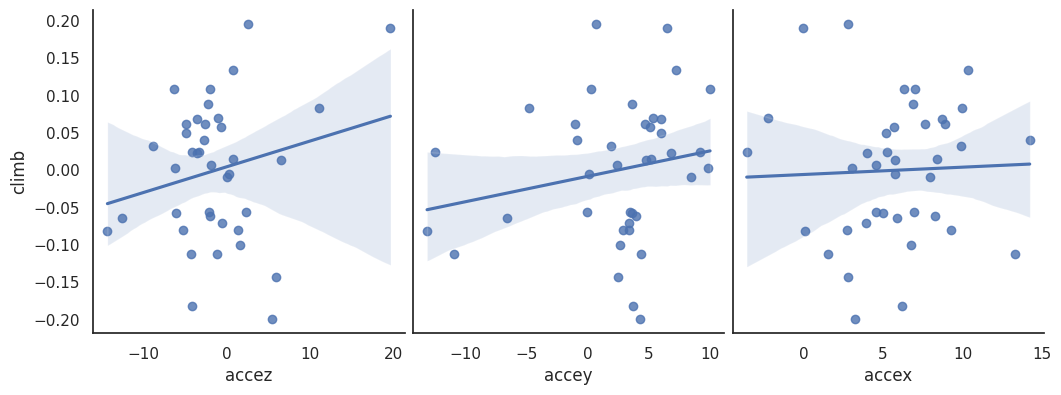

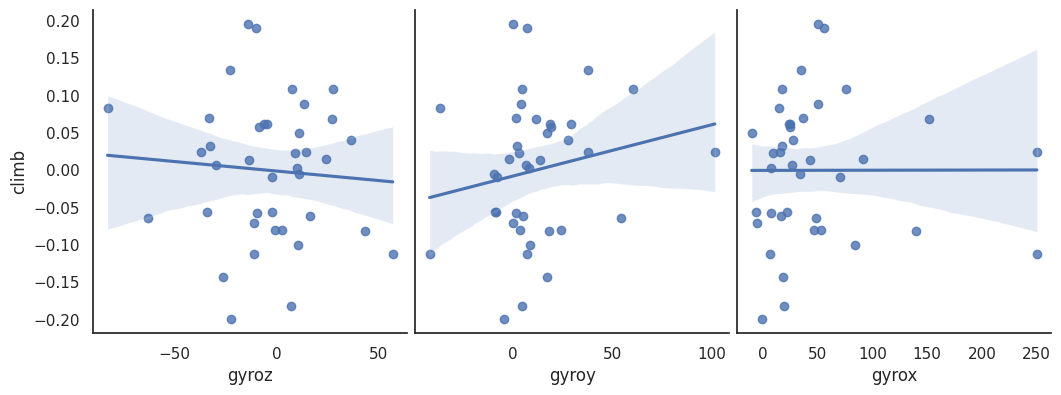

In [ ]:
sns.pairplot(pck_k0, x_vars=["accez",'accey',"accex"], y_vars=["climb"], height=4, aspect=.9, kind="reg");
sns.pairplot(pck_k0, x_vars=["gyroz",'gyroy',"gyrox"], y_vars=["climb"], height=4, aspect=.9, kind="reg");

In [ ]:
fignew1 = px.scatter(y=pck_k1['latitude'],
                    x=pck_k1['longitude'],
                    size=pck_k1['us_lpd'],
                    color=pck_k1['KMeans_3'],
                    color_continuous_scale=[(0.00, "blue"),
                                            (0.33, "blue"),
                                            (0.33, "orange"),
                                            (0.66, "orange"),
                                            (0.66, "red"),
                                            (1.00, "red")], size_max=30)

fignew1.update_layout(title={'text':'Cluster Analysis',
                            'y':0.95,
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'},
                    xaxis_title="Longitude",
                    yaxis_title="Latitude")
fignew1.show()

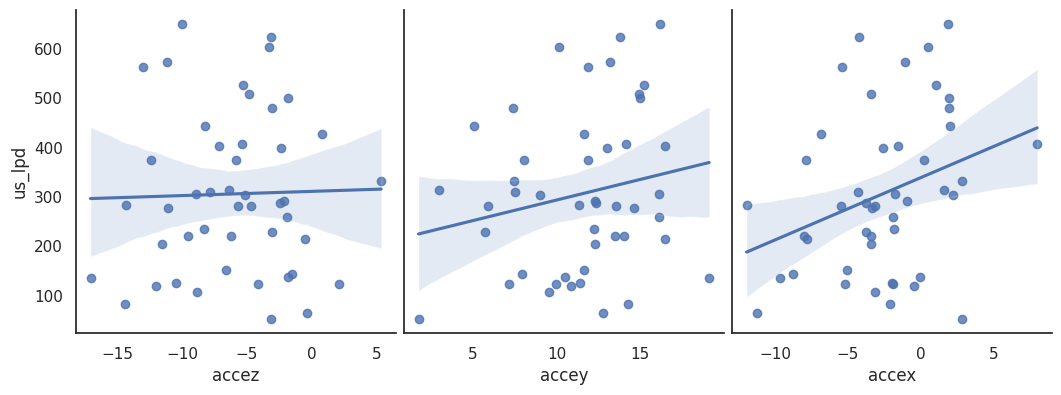

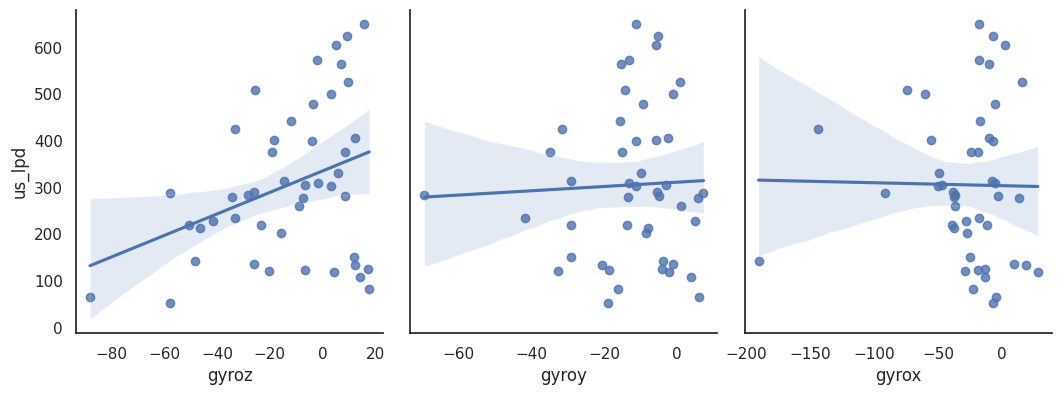

In [ ]:
sns.pairplot(pck_k1, x_vars=["accez",'accey',"accex"], y_vars=["us_lpd"], height=4, aspect=.9, kind="reg");
sns.pairplot(pck_k1, x_vars=["gyroz",'gyroy',"gyrox"], y_vars=["us_lpd"], height=4, aspect=.9, kind="reg");

In [ ]:
fignew2 = px.scatter(y=pck_k2['latitude'],
                    x=pck_k2['longitude'],
                    size=pck_k2['us_lpd'],
                    color=pck_k2['KMeans_3'],
                    color_continuous_scale=[(0.00, "red"),
                                            (1.00, "red"),
                                            ], size_max=30)
fignew2.update_layout(title={'text':'Cluster Analysis',
                            'y':0.95,
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'},
                    xaxis_title="Longitude",
                    yaxis_title="Latitude")
fignew2.show()

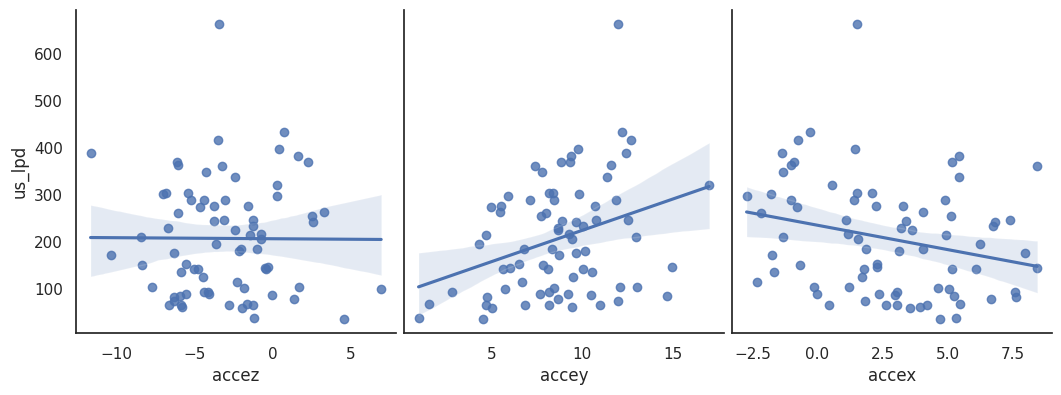

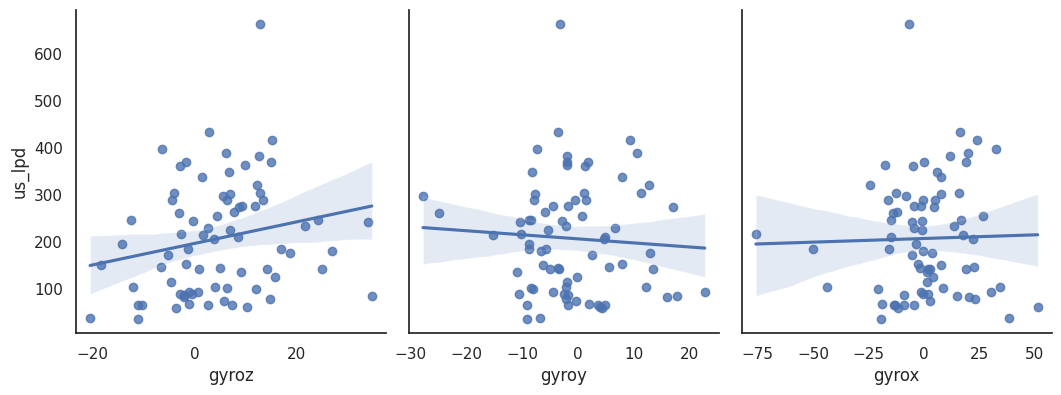

In [ ]:
sns.pairplot(pck_k2, x_vars=["accez",'accey',"accex"], y_vars=["us_lpd"], height=4, aspect=.9, kind="reg");
sns.pairplot(pck_k2, x_vars=["gyroz",'gyroy',"gyrox"], y_vars=["us_lpd"], height=4, aspect=.9, kind="reg");

In [ ]:
pck_k0.describe().round(4)

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,speed,KMeans_3
count,39.00,39.00,39.00,39.00,39.00,39.00,39.00,39.00,39.00,39.00,39.00,39.00
mean,-15.80,-47.91,5.71,2.36,-1.41,-0.00,47.17,11.24,-3.96,313.94,8.11,0.00
std,0.01,0.01,3.73,5.51,5.90,0.09,59.41,24.53,27.30,172.04,1.32,0.00
min,-15.81,-47.92,-3.59,-13.16,-14.36,-0.20,-10.40,-41.96,-82.98,63.54,5.62,0.00
25%,-15.80,-47.91,3.57,0.47,-4.28,-0.07,16.02,0.83,-18.32,183.73,7.36,0.00
50%,-15.80,-47.90,5.77,3.59,-2.07,0.01,26.89,6.82,-2.59,311.86,8.17,0.00
75%,-15.79,-47.90,8.11,5.27,0.72,0.06,51.45,18.34,10.83,463.45,9.17,0.00
max,-15.79,-47.90,14.22,10.01,19.61,0.20,250.13,101.72,56.77,693.17,10.26,0.00


In [ ]:
pck_k1.describe().round(4)

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,speed,KMeans_3
count,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00
mean,-15.80,-47.91,-2.61,11.47,-6.06,-0.05,-27.63,-12.36,-12.93,305.41,8.25,1.00
std,0.01,0.01,4.05,3.79,4.75,0.08,38.60,14.44,24.18,161.78,1.37,0.00
min,-15.81,-47.93,-11.95,1.74,-17.03,-0.24,-190.64,-69.29,-88.27,52.96,4.73,1.00
25%,-15.81,-47.92,-4.88,9.12,-9.40,-0.09,-37.60,-16.02,-26.11,164.24,7.67,1.00
50%,-15.80,-47.91,-2.36,12.06,-5.53,-0.06,-18.36,-10.54,-7.00,285.25,8.52,1.00
75%,-15.79,-47.90,0.18,14.12,-2.59,-0.01,-6.75,-3.20,6.71,404.92,9.24,1.00
max,-15.79,-47.90,8.00,19.12,5.34,0.13,28.18,7.30,17.74,648.89,10.63,1.00


In [ ]:
pck_k2.describe().round(4)

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,speed,KMeans_3
count,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00
mean,-15.80,-47.91,2.71,8.72,-3.03,0.02,1.03,-1.05,4.67,206.51,5.73,2.00
std,0.01,0.01,2.94,2.99,3.44,0.06,19.56,8.93,11.01,120.35,1.80,0.00
min,-15.81,-47.93,-2.73,1.00,-11.69,-0.10,-75.81,-27.74,-20.53,35.63,0.00,2.00
25%,-15.81,-47.92,0.49,6.82,-5.69,-0.03,-8.87,-7.06,-2.36,100.13,4.67,2.00
50%,-15.80,-47.91,2.62,8.69,-3.27,0.02,-0.35,-1.98,4.49,193.69,5.75,2.00
75%,-15.80,-47.91,5.09,10.50,-0.90,0.06,14.14,4.15,11.96,287.83,6.84,2.00
max,-15.79,-47.90,8.45,16.99,6.96,0.15,51.44,22.73,34.89,663.03,8.91,2.00


###Cluster distribution comparation

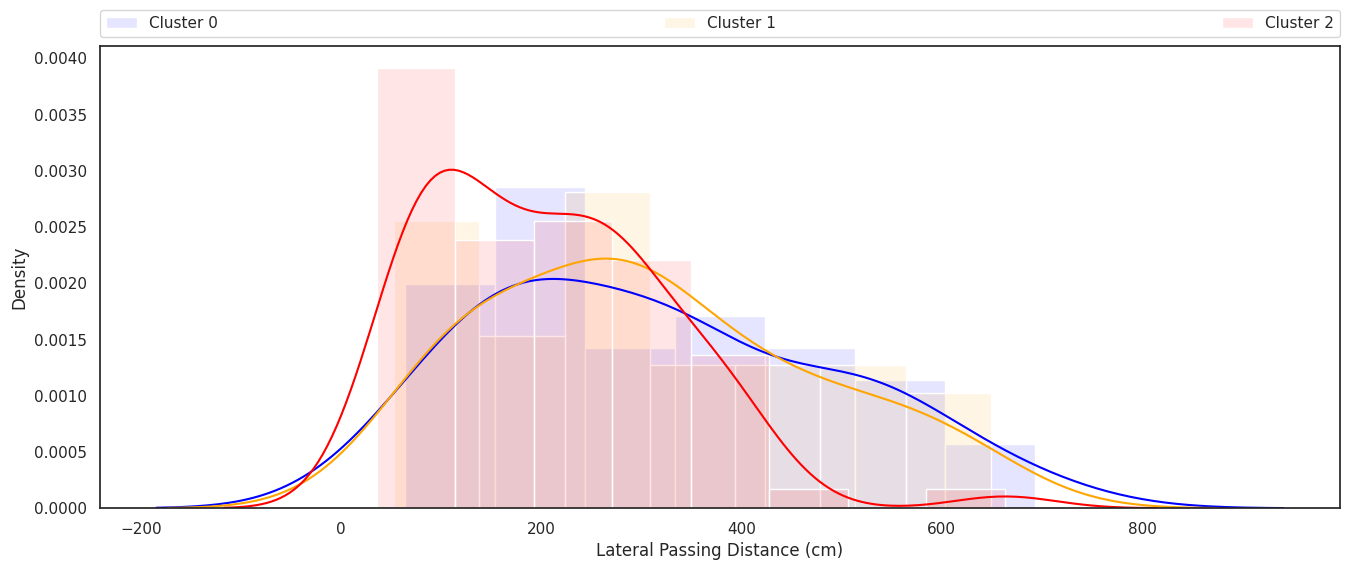

In [ ]:
f, axes = plt.subplots(figsize=(16,6))
# sns.set_palette('colorblind')

ax = sns.histplot(pck_k0['us_lpd'], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.1, color='blue', label='Cluster 0')
ax1 = sns.histplot(pck_k1['us_lpd'],kde=True, stat="density", kde_kws=dict(cut=3), alpha=.1, color='orange', label='Cluster 1')
ax2 = sns.histplot(pck_k2['us_lpd'], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.1, color='red', label='Cluster 2')

ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0.)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0.)

ax1.set_xlabel("Lateral Passing Distance (cm)")
plt.ylabel('Density')

plt.show()

In [ ]:
pd.options.display.float_format = "{:,.2f}".format

# Resumo estatístico da distribuíção da duração das viagens
summary = pd.DataFrame(data=[pck_k0['us_lpd'].describe(),
                            pck_k1['us_lpd'].describe(),
                            pck_k2['us_lpd'].describe()],
                      index=['Cluster 0','Cluster 1','Cluster 2'])

summary.columns = ['samples','mean','std','min','25%','50%','75%','max']
summary

,samples,mean,std,min,25%,50%,75%,max
Cluster 0,39.00,313.94,172.04,63.54,183.73,311.86,463.45,693.17
Cluster 1,46.00,305.41,161.78,52.96,164.24,285.25,404.91,648.89
Cluster 2,75.00,206.51,120.35,35.63,100.13,193.69,287.83,663.03


In [ ]:
# Teste KS para comparar as distribuições - Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
from scipy import stats
print('KS test: {}'.format(stats.ks_2samp(pck_k0['us_lpd'], pck_k1['us_lpd'])))
print('KS test: {}'.format(stats.ks_2samp(pck_k1['us_lpd'], pck_k2['us_lpd'])))
print('KS test: {}'.format(stats.ks_2samp(pck_k0['us_lpd'], pck_k2['us_lpd'])))

KS test: KstestResult(statistic=0.12764771460423635, pvalue=0.8238176162759316, statistic_location=210.96, statistic_sign=1)
KS test: KstestResult(statistic=0.32028985507246377, pvalue=0.004192225351916888, statistic_location=276.04, statistic_sign=-1)
KS test: KstestResult(statistic=0.3394871794871795, pvalue=0.0038294815531883177, statistic_location=303.85, statistic_sign=-1)


In [ ]:
print('Teste KS: {}'.format(stats.ks_2samp(pck_k0['climb'], pck_k1['climb'])))
print('Teste KS: {}'.format(stats.ks_2samp(pck_k1['climb'], pck_k2['climb'])))
print('Teste KS: {}'.format(stats.ks_2samp(pck_k0['climb'], pck_k2['climb'])))

Teste KS: KstestResult(statistic=0.35451505016722407, pvalue=0.006953183612180064, statistic_location=-0.012, statistic_sign=-1)
Teste KS: KstestResult(statistic=0.42840579710144927, pvalue=3.033219303808759e-05, statistic_location=-0.057, statistic_sign=1)
Teste KS: KstestResult(statistic=0.26461538461538464, pvalue=0.043568290976979444, statistic_location=-0.056, statistic_sign=1)


In [ ]:
# from scipy.stats import f_oneway

# cluster_groups = [pck.loc[pck['KMeans_3']==0, 'us_lpd'].values for arm in pck['KMeans_3'].dropna().unique()]
# stat, p_value = f_oneway(*cluster_groups)
# print(f"F Test: statistic={stat:.4f}, p-value={p_value:.4f}")

In [ ]:
from scipy.stats import f_oneway
k0 = pck_k0[['accex','accey','accez','climb','gyrox','gyroy','gyroz','us_lpd','speed']]
k1 = pck_k1[['accex','accey','accez','climb','gyrox','gyroy','gyroz','us_lpd','speed']]
k2 = pck_k2[['accex','accey','accez','climb','gyrox','gyroy','gyroz','us_lpd','speed']]

ANOVA = f_oneway(k0, k1, k2, axis=0)
ANOVA

F_onewayResult(statistic=array([63.77449166, 58.4908886 , 11.96971841, 12.07495276, 40.83246372,
       24.20189176, 11.04281432,  9.83461483, 48.61941418]), pvalue=array([5.33083465e-21, 1.03985063e-19, 1.45132216e-05, 1.32474086e-05,
       5.26886895e-15, 6.89223779e-10, 3.25727897e-05, 9.46217244e-05,
       3.68667841e-17]))


os centros estão vindo escalados - ver possibilidade de listas eles sem a escala normalizada

In [ ]:
centers = kmeans.cluster_centers_
centers

array([[ 0.7789723 , -0.06889611, -0.55477785,  2.11299047],
       [ 0.74756398,  0.01644405,  0.73649096, -0.43622049],
       [-0.87520163, -0.48199287,  0.30886665, -0.4738106 ],
       [-1.18672975, -0.54405603,  0.26428872,  2.11299047],
       [-0.23800289,  1.97111156,  0.93453465, -0.43500604],
       [ 0.33937012, -0.23362328, -1.02910372, -0.51142496]])

parentesis para ver centros de diferentes clusters

In [ ]:
#   #Para ver os centros do caso pontual de n clusters

# kmeans = KMeans(n_clusters=3)
# kmeans.fit(pck[['accex_t', 'accey_t', 'accez_T', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'climb_t', 'us_lpd_t', 'speed_t']])
# #X['cluster_label'] = kmeans.fit_predict(X)
# #centers = kmeans.cluster_centers_
# #labels = kmeans.predict(df[['Latitude', 'Longitude', 'Usreading R']])

# kmeans.cluster_centers_

In [ ]:
# from sklear.preprocessing import OrdinalEncoder

# oe = OrdinalEncoder()
# X = or.fit_transform(X)

In [ ]:
kmeans.cluster_centers_

array([[ 0.7789723 , -0.06889611, -0.55477785,  2.11299047],
       [ 0.74756398,  0.01644405,  0.73649096, -0.43622049],
       [-0.87520163, -0.48199287,  0.30886665, -0.4738106 ],
       [-1.18672975, -0.54405603,  0.26428872,  2.11299047],
       [-0.23800289,  1.97111156,  0.93453465, -0.43500604],
       [ 0.33937012, -0.23362328, -1.02910372, -0.51142496]])

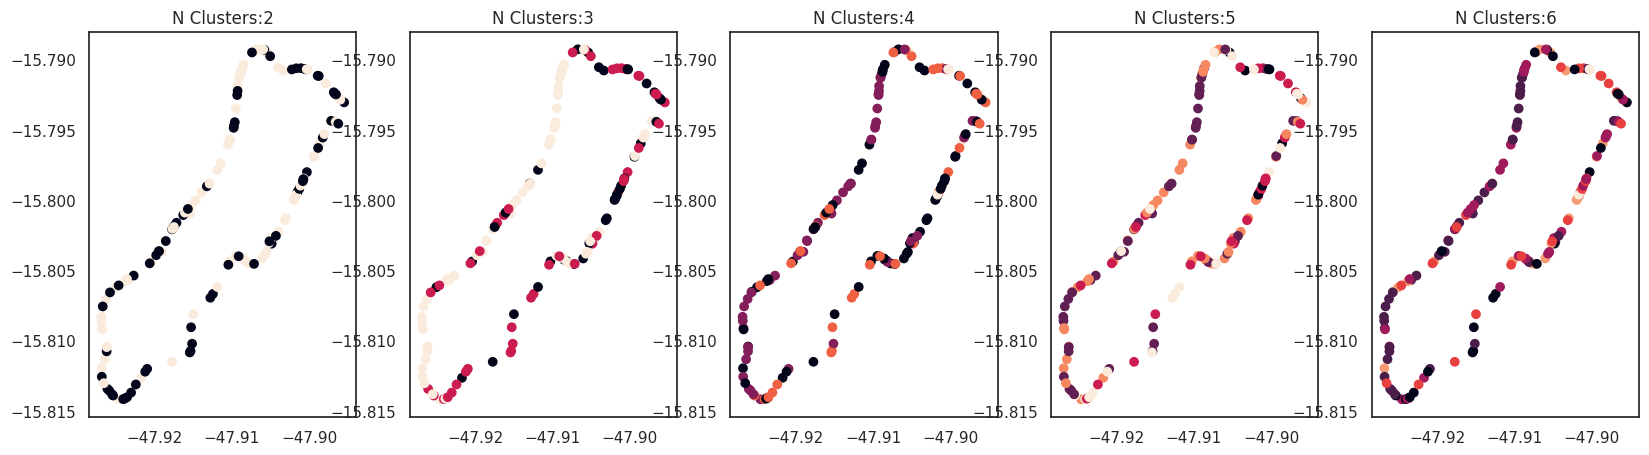

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
for i, ax in enumerate(fig.axes, start=2):
    ax.scatter(y=pck['latitude'], x=pck['longitude'], c=pck[f'KMeans_{i}'])
    ax.set_title(f'N Clusters:{i}')

silhouette score for k-means

In [ ]:
pck['KMeans_3'].describe()

count   160.00
mean      1.23
std       0.82
min       0.00
25%       1.00
50%       1.00
75%       2.00
max       2.00
Name: KMeans_3, dtype: float64

In [ ]:
pck[['us_lpd','speed', 'climb']].describe()

,us_lpd,speed,climb
count,160.00,160.00,160.00
mean,261.13,7.03,-0.01
std,154.53,1.99,0.08
min,35.63,0.00,-0.24
25%,139.62,5.61,-0.06
50%,238.78,7.33,-0.01
75%,351.08,8.61,0.05
max,693.17,10.63,0.20


###Feature Silhouette Analysis

In [ ]:
from sklearn import metrics

  #total
X2 = pck[['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t']]
kmeans_model = KMeans(n_clusters=3, random_state=42, init='k-means++', n_init=42).fit(X2)
labels = kmeans_model.labels_
metrics.silhouette_score(X2, labels, metric='euclidean')

0.1423422950395586

In [ ]:
  #3 + acce

X3 = pck[['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t']]
kmeans_model = KMeans(n_clusters=3, random_state=42, init='k-means++', n_init=42).fit(X3)
labels = kmeans_model.labels_
metrics.silhouette_score(X3, labels, metric='euclidean')

0.161174532868594

In [ ]:
  #3 + gyro

X7 = pck[['climb_t', 'us_lpd_t', 'speed_t', 'gyrox_t', 'gyroy_t', 'gyroz_t']]
kmeans_model = KMeans(n_clusters=3, random_state=42, init='k-means++', n_init=42).fit(X7)
labels = kmeans_model.labels_
metrics.silhouette_score(X7, labels, metric='euclidean')

0.2160017186718916

In [ ]:
  #3 = n_clusters ruim

X4 = pck[['climb_t', 'us_lpd_t', 'speed_t']]
kmeans_model = KMeans(n_clusters=3, random_state=42, init='k-means++', n_init=42).fit(X4)
labels = kmeans_model.labels_
metrics.silhouette_score(X4, labels, metric='euclidean')

0.26282024703829093

In [ ]:
X5 = pck[['climb_t', 'us_lpd_t']]
kmeans_model = KMeans(n_clusters=3, random_state=42, init='k-means++', n_init=42).fit(X5)
labels = kmeans_model.labels_
metrics.silhouette_score(X5, labels, metric='euclidean')

0.356443759031522

In [ ]:
X6 = pck[['speed_t', 'us_lpd_t']]
kmeans_model = KMeans(n_clusters=3, random_state=42, init='k-means++', n_init=42).fit(X6)
labels = kmeans_model.labels_
metrics.silhouette_score(X6, labels, metric='euclidean')

0.3919565654998533

### PCA test

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

X = np.array(pck[['climb_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'us_lpd_t']])
pca = PCA(n_components=2)
x = pca.fit_transform(X)

print(pca.explained_variance_ratio_)

[0.28179234 0.15122252]


In [ ]:
Xt = np.array(pck[['climb', 'speed', 'accex', 'accey', 'accez', 'gyrox', 'gyroy', 'gyroz','us_lpd']])
pca = PCA(n_components=2)
xt = pca.fit_transform(Xt)

print(pca.explained_variance_ratio_)

[0.88762231 0.08572615]


In [ ]:
cols = pck[['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'us_lpd_t']].columns.tolist()


In [ ]:
dt = pd.DataFrame(xt)
dt['us_lpd'] = pck['us_lpd_t']

d = pd.DataFrame(xt)
d['us_lpd'] = pck['us_lpd']

<Axes: >

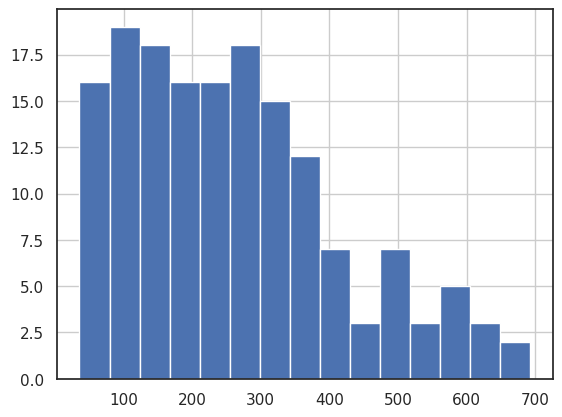

In [ ]:
pck['us_lpd'].hist(bins=15)

In [ ]:
px.scatter(dt, x=1,y=0, color='us_lpd')

In [ ]:
px.scatter(d, x=1,y=0, color='us_lpd',
           color_continuous_scale=[(0.00, "red"),
                                   (0.33, "red"),
                                   (0.33, "orange"),
                                   (0.66, "orange"),
                                   (0.66, "blue"),
                                   (1.00, "blue")])

In [ ]:
c1 = pck[pck['KMeans_3']==0]

####Fim K-means

#*DBSCAN* - Greg

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/MSc/park_analysis4_total.xlsx")

In [ ]:
pcD = df.copy()

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
pcD.rename(columns = {' us_lpd_left':'us_lpd'}, inplace = True)

In [ ]:
# DBSCAN is not sensitive to scalar variation like k-means
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# pcD[['climb_t', 'us_lpd_left_t', 'speed_t']] = scaler.fit_transform(pcD[[ 'climb', ' us_lpd_left', 'speed']])
# pcD

In [ ]:
pcD.head()

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,speed
0,-15.80,-47.91,2.81,0.69,2.49,0.20,49.95,0.29,-14.37,189.04,9.06
1,-15.80,-47.91,-0.06,6.45,19.61,0.19,55.76,7.35,-10.39,160.03,6.72
2,-15.81,-47.93,0.42,8.18,-5.91,0.15,-8.72,-1.82,-10.40,65.30,3.85
3,-15.79,-47.91,5.16,8.14,-5.07,0.14,19.11,13.54,0.82,140.94,4.42
4,-15.80,-47.91,3.62,8.69,-2.39,0.14,-0.66,-5.30,7.04,223.68,6.65


In [ ]:
lat_long_read = pcD[['latitude','longitude','climb','speed','us_lpd']]
lat, longg, climb, speed, lpd = pcD.latitude, pcD.longitude, pcD.climb, pcD.speed, pcD.us_lpd

# plt.scatter(climb,lpd,speed)

In [ ]:
X = pcD[['latitude', 'longitude','climb','speed', 'us_lpd']]

from sklearn.cluster import DBSCAN
X = lat_long_read.to_numpy()

dbscan_cluster_model = DBSCAN(eps=0.00025, min_samples=2).fit(X)
dbscan_cluster_model

DBSCAN(eps=0.00025, min_samples=2)

In [ ]:
pcD['cluster'] = dbscan_cluster_model.labels_
pcD.head()

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,speed,cluster
0,-15.80,-47.91,2.81,0.69,2.49,0.20,49.95,0.29,-14.37,189.04,9.06,-1
1,-15.80,-47.91,-0.06,6.45,19.61,0.19,55.76,7.35,-10.39,160.03,6.72,-1
2,-15.81,-47.93,0.42,8.18,-5.91,0.15,-8.72,-1.82,-10.40,65.30,3.85,-1
3,-15.79,-47.91,5.16,8.14,-5.07,0.14,19.11,13.54,0.82,140.94,4.42,-1
4,-15.80,-47.91,3.62,8.69,-2.39,0.14,-0.66,-5.30,7.04,223.68,6.65,-1


In [ ]:
pcD['cluster'].value_counts()

-1    161
Name: cluster, dtype: int64

https://colab.research.google.com/drive/1DphvjpgQXwBWQq08dMyoSc6UREzXLxSE?usp=sharing#scrollTo=aWZJXk5aXcZX
testar encontrar melhor esp e min_sample

In [ ]:
# px.scatter_3d(data_frame=pcD,x=longg, y=lat, z=lpd, color=pcD['cluster'],template='plotly_white',
#              title='3D Scatter plot for KMeans Clusters')

In [ ]:
# from sklearn.metrics import silhouette_score as ss
# ss(X, pcD['cluster'])

In [ ]:
epsilons = np.linspace(0.01, 1, num=15)
epsilons

array([0.01      , 0.08071429, 0.15142857, 0.22214286, 0.29285714,
       0.36357143, 0.43428571, 0.505     , 0.57571429, 0.64642857,
       0.71714286, 0.78785714, 0.85857143, 0.92928571, 1.        ])

In [ ]:
min_samples = np.arange(2, 20, step=3)
min_samples

array([ 2,  5,  8, 11, 14, 17])

In [ ]:
import itertools
combinations = list(itertools.product(epsilons, min_samples))
combinations

[(0.01, 2),
 (0.01, 5),
 (0.01, 8),
 (0.01, 11),
 (0.01, 14),
 (0.01, 17),
 (0.08071428571428571, 2),
 (0.08071428571428571, 5),
 (0.08071428571428571, 8),
 (0.08071428571428571, 11),
 (0.08071428571428571, 14),
 (0.08071428571428571, 17),
 (0.15142857142857144, 2),
 (0.15142857142857144, 5),
 (0.15142857142857144, 8),
 (0.15142857142857144, 11),
 (0.15142857142857144, 14),
 (0.15142857142857144, 17),
 (0.22214285714285714, 2),
 (0.22214285714285714, 5),
 (0.22214285714285714, 8),
 (0.22214285714285714, 11),
 (0.22214285714285714, 14),
 (0.22214285714285714, 17),
 (0.29285714285714287, 2),
 (0.29285714285714287, 5),
 (0.29285714285714287, 8),
 (0.29285714285714287, 11),
 (0.29285714285714287, 14),
 (0.29285714285714287, 17),
 (0.3635714285714286, 2),
 (0.3635714285714286, 5),
 (0.3635714285714286, 8),
 (0.3635714285714286, 11),
 (0.3635714285714286, 14),
 (0.3635714285714286, 17),
 (0.4342857142857143, 2),
 (0.4342857142857143, 5),
 (0.4342857142857143, 8),
 (0.4342857142857143, 11),
 

In [ ]:
combinations = list(itertools.product(epsilons, min_samples))
N = len(combinations)
N

90

In [ ]:
def get_scores_and_labels(combinations, X):
  scores = []
  all_labels_list = []

  for i, (eps, num_samples) in enumerate(combinations):
    dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
    labels = dbscan_cluster_model.labels_
    labels_set = set(labels)
    num_clusters = len(labels_set)
    if -1 in labels_set:
      num_clusters -= 1

    if (num_clusters < 2) or (num_clusters > 50):
      scores.append(-10)
      all_labels_list.append('bad')
      c = (eps, num_samples)
      print(f"Combination {c} on iteration {i+1} of {N} has {num_clusters} clusters. Moving on")
      continue

    scores.append(ss(X, labels))
    all_labels_list.append(labels)
    print(f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, NumClusters: {num_clusters}")

  best_index = np.argmax(scores)
  best_parameters = combinations[best_index]
  best_labels = all_labels_list[best_index]
  best_score = scores[best_index]

  return {'best_epsilon': best_parameters[0],
          'best_min_samples': best_parameters[1],
          'best_labels': best_labels,
          'best_score': best_score}

best_dict = get_scores_and_labels(combinations, X)

Combination (0.01, 2) on iteration 1 of 90 has 0 clusters. Moving on
Combination (0.01, 5) on iteration 2 of 90 has 0 clusters. Moving on
Combination (0.01, 8) on iteration 3 of 90 has 0 clusters. Moving on
Combination (0.01, 11) on iteration 4 of 90 has 0 clusters. Moving on
Combination (0.01, 14) on iteration 5 of 90 has 0 clusters. Moving on
Combination (0.01, 17) on iteration 6 of 90 has 0 clusters. Moving on
Combination (0.08071428571428571, 2) on iteration 7 of 90 has 0 clusters. Moving on
Combination (0.08071428571428571, 5) on iteration 8 of 90 has 0 clusters. Moving on
Combination (0.08071428571428571, 8) on iteration 9 of 90 has 0 clusters. Moving on
Combination (0.08071428571428571, 11) on iteration 10 of 90 has 0 clusters. Moving on
Combination (0.08071428571428571, 14) on iteration 11 of 90 has 0 clusters. Moving on
Combination (0.08071428571428571, 17) on iteration 12 of 90 has 0 clusters. Moving on
Combination (0.15142857142857144, 2) on iteration 13 of 90 has 0 clusters

Epsilon, MinSamples and Silhouette Score for DBSCAN

In [ ]:
best_dict

{'best_epsilon': 0.4342857142857143,
 'best_min_samples': 2,
 'best_labels': array([-1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1,  1, -1, -1, -1, -1, -1]),
 'best_score': -0.48985380260702777}

Clusters and Noise Points

In [ ]:
pcD['cluster'] = best_dict['best_labels']
pcD['cluster'].value_counts()

-1    156
 0      3
 1      2
Name: cluster, dtype: int64

In [ ]:
len(set('cluster'))

7

## DBSCAN Representation

In [ ]:
figdbscan = px.scatter(x=longg, y=lat, color=pcD['cluster'],
                 color_continuous_scale=[(0.00, "red"),
                                         (0.33, "red"),
                                         (0.33, "orange"),
                                         (0.66, "orange"),
                                         (0.66, "blue"),
                                         (1.00, "blue")], size_max=25)

figdbscan.update_layout(title={'text':'DBSCAN Cluster Analysis',
                            'y':0.95,
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'},
                     xaxis_title="Longitude",
                     yaxis_title="Latitude")

figdbscan.show()

Silhouette Score for DBSCAN

In [ ]:
ss(X, pcD['cluster'])

-0.48985380260702777

In [ ]:
# px.scatter_3d(data_frame=pcD,x=longg, y=lat, z=lpd, color=pcD['cluster'],template='plotly_white',
#              title='3D Scatter plot for KMeans Clusters')

#### Fim DBSCAN

# Correlation Analysis

In [ ]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

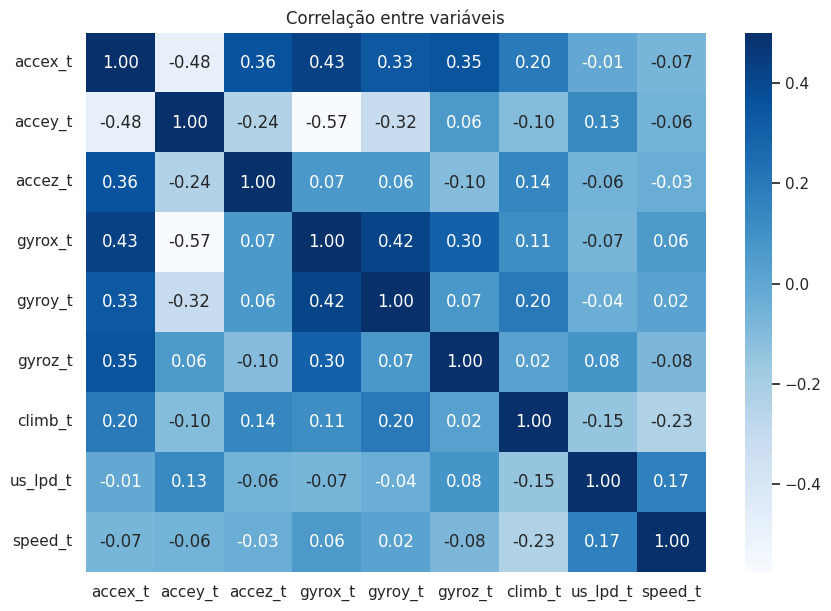

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(pck[['accex_t', 'accey_t', 'accez_t',
                 'gyrox_t', 'gyroy_t', 'gyroz_t',
                 'climb_t', 'us_lpd_t', 'speed_t']].corr(),
            annot = True,
            vmax=.5,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis')
plt.show()

<Axes: >

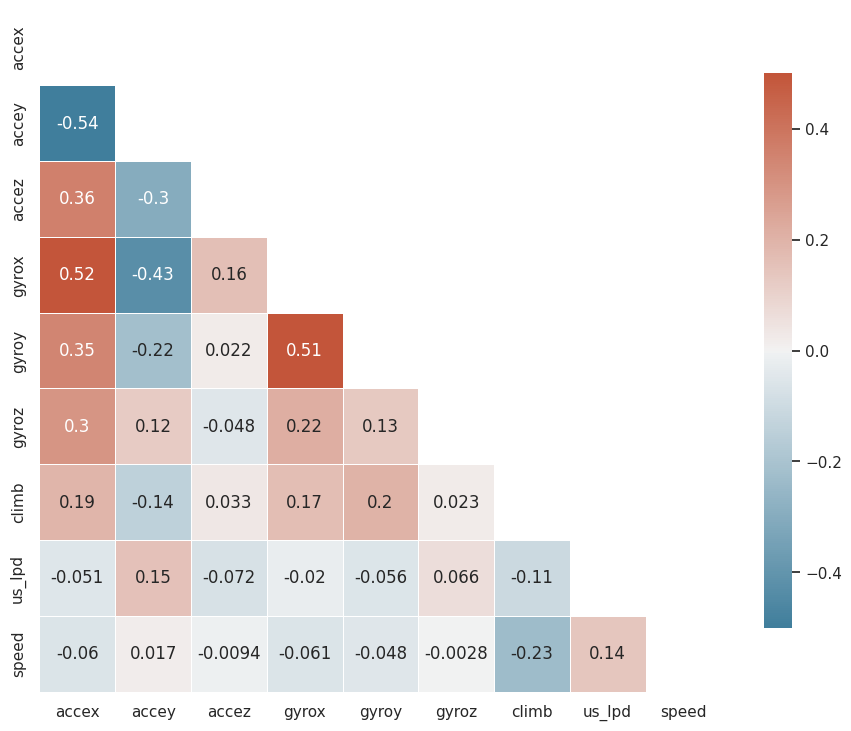

In [ ]:
from string import ascii_letters
sns.set_theme(style="white")

# Compute the correlation matrix
corr = pck[['accex', 'accey', 'accez',
            'gyrox', 'gyroy', 'gyroz',
            'climb', 'us_lpd', 'speed']].corr(method = 'spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot = True, vmax=.5, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

<Axes: >

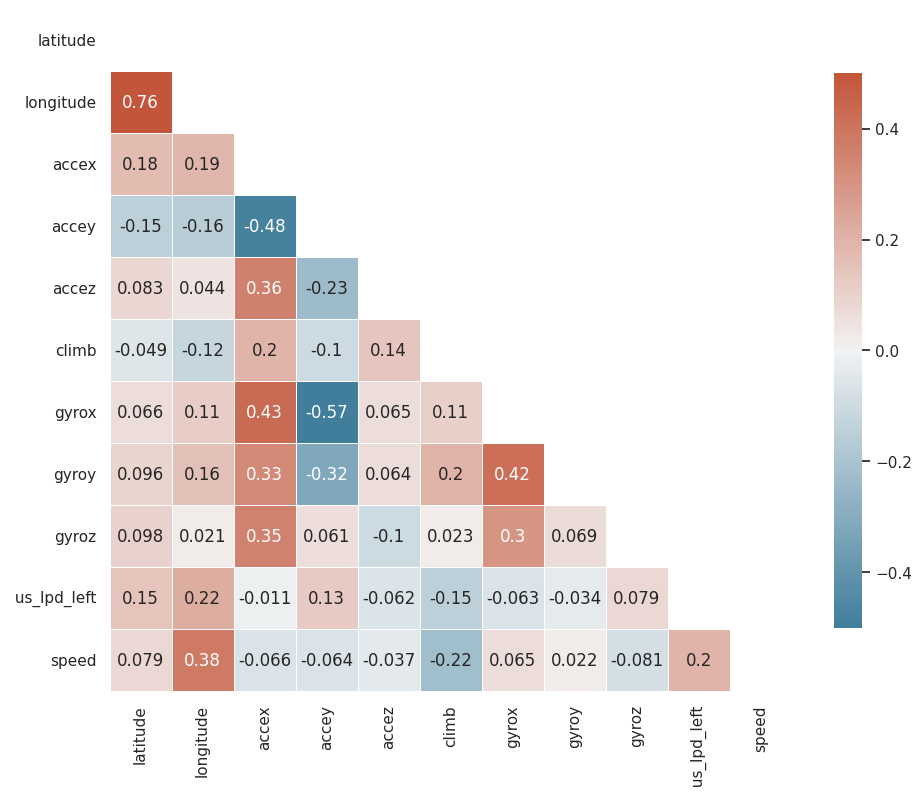

In [ ]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot = True, vmax=.5, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

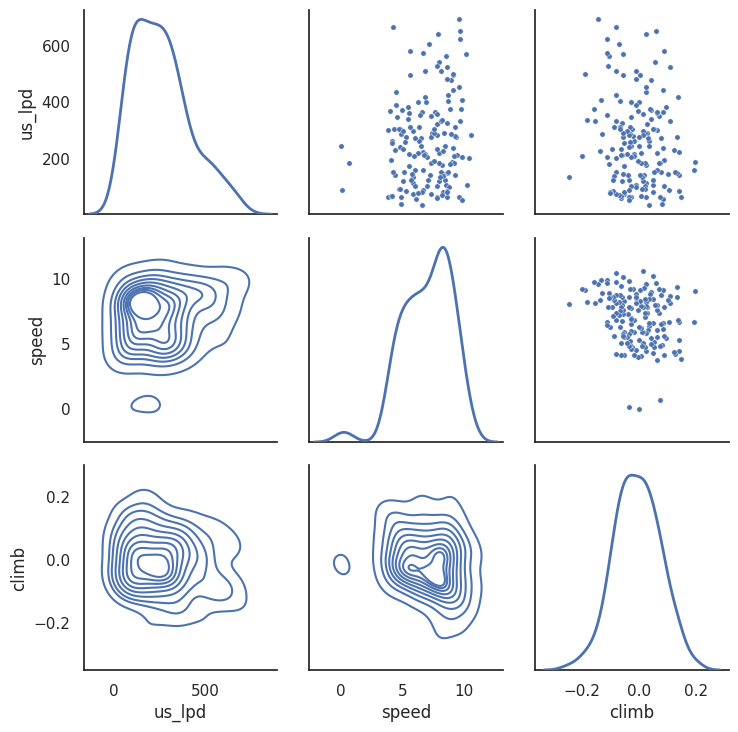

In [ ]:
sns.set_theme(style="white")
g = sns.PairGrid(pck[['us_lpd', 'speed', 'climb']], diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

#Traffic Volume Analysis

In [ ]:
volume = pd.read_excel('/content/drive/MyDrive/MSc/pdc_volume.xlsx')

In [ ]:
volume.head()

,trecho,latitude,longitude,accey,climb,us_lpd,speed,volume
0,3,-15.81,-47.93,8.18,0.15,65.30,3.85,330
1,3,-15.81,-47.93,10.47,0.14,86.18,5.32,330
2,3,-15.81,-47.93,6.55,0.12,152.27,4.22,330
3,3,-15.81,-47.92,14.97,0.10,145.13,8.38,330
4,3,-15.81,-47.93,9.38,0.10,382.20,5.43,330


In [ ]:
volume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   trecho     115 non-null    int64  
 1   latitude   115 non-null    float64
 2   longitude  115 non-null    float64
 3   accey      115 non-null    float64
 4   climb      115 non-null    float64
 5    us_lpd    115 non-null    float64
 6   speed      115 non-null    float64
 7   volume     115 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 7.3 KB


In [ ]:
volume_t = volume.copy()
volume_t.head()

,trecho,latitude,longitude,accey,climb,us_lpd,speed,volume
0,3,-15.81,-47.93,8.18,0.15,65.30,3.85,330
1,3,-15.81,-47.93,10.47,0.14,86.18,5.32,330
2,3,-15.81,-47.93,6.55,0.12,152.27,4.22,330
3,3,-15.81,-47.92,14.97,0.10,145.13,8.38,330
4,3,-15.81,-47.93,9.38,0.10,382.20,5.43,330


In [ ]:
volume_t.describe()

,trecho,latitude,longitude,accey,climb,us_lpd,speed,volume
count,115.00,115.00,115.00,115.00,115.00,115.00,115.00,115.00
mean,1.67,-15.80,-47.91,8.24,0.01,242.60,6.47,147.50
std,0.77,0.01,0.01,4.48,0.08,142.48,1.85,86.75
min,1.00,-15.81,-47.93,-12.51,-0.24,35.63,0.12,103.00
25%,1.00,-15.81,-47.92,5.67,-0.04,129.39,5.05,103.00
50%,1.00,-15.80,-47.91,8.43,0.01,227.48,6.55,103.00
75%,2.00,-15.80,-47.90,10.76,0.06,325.77,7.86,113.00
max,3.00,-15.79,-47.90,19.12,0.19,648.89,10.63,330.00


In [ ]:
scaler = StandardScaler()
volume_t[['accey_t', 'climb_t','us_lpd_t','speed_t', 'volume_t']] = scaler.fit_transform(volume_t[['accey',	'climb',' us_lpd', 'speed',	'volume']])
volume_t.head()

,trecho,latitude,longitude,accey,climb,us_lpd,speed,volume,accey_t,climb_t,us_lpd_t,speed_t,volume_t
0,3,-15.81,-47.93,8.18,0.15,65.30,3.85,330,-0.01,1.79,-1.25,-1.42,2.11
1,3,-15.81,-47.93,10.47,0.14,86.18,5.32,330,0.50,1.67,-1.10,-0.62,2.11
2,3,-15.81,-47.93,6.55,0.12,152.27,4.22,330,-0.38,1.50,-0.64,-1.22,2.11
3,3,-15.81,-47.92,14.97,0.10,145.13,8.38,330,1.51,1.19,-0.69,1.04,2.11
4,3,-15.81,-47.93,9.38,0.10,382.20,5.43,330,0.26,1.11,0.98,-0.56,2.11


Elbow Method for Optimal number of Clusters

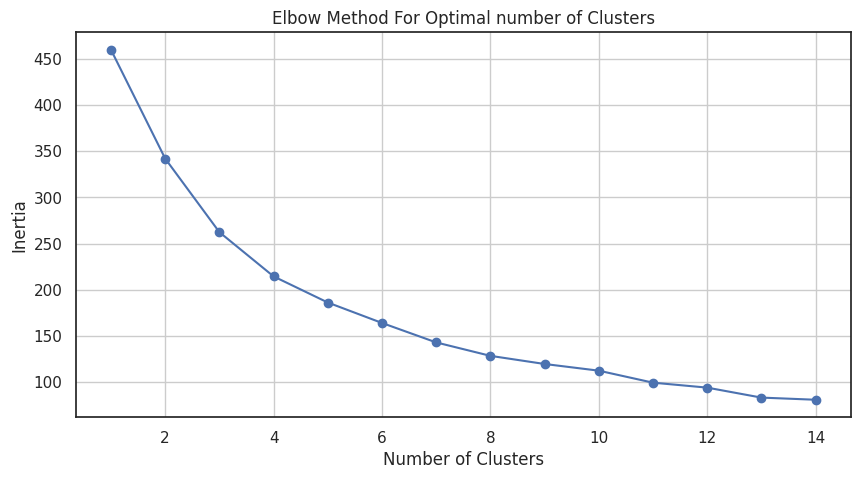

In [ ]:
optimise_k_means(volume_t[['climb_t', 'us_lpd_t', 'speed_t', 'volume_t']], 15)

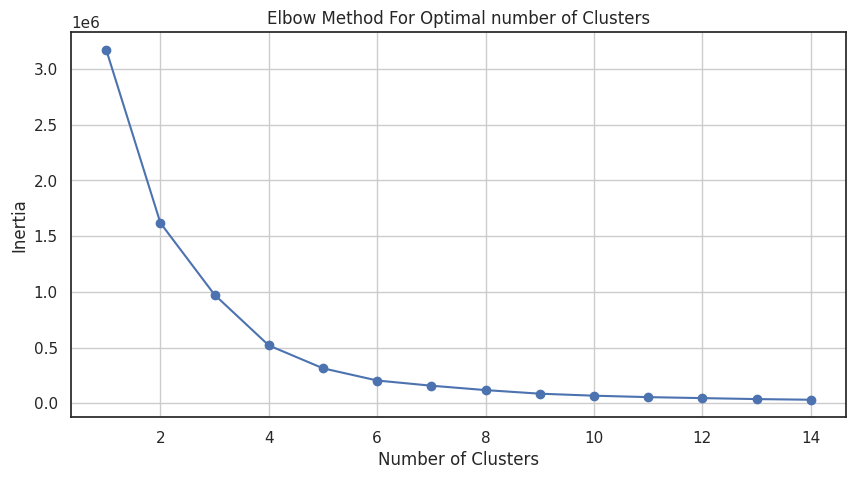

In [ ]:
optimise_k_means(volume[['climb', ' us_lpd', 'speed', 'volume']], 15)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 17]
silscore = []
X2 = volume_t[[ 'us_lpd_t', 'volume_t']].copy()

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X2)
    silhouette_avg = silhouette_score(X2, cluster_labels)
    silscore.append(silhouette_avg)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X2, cluster_labels)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 2 The average silhouette_score is : 0.6155615039769924
For n_clusters = 3 The average silhouette_score is : 0.5693937339101394
For n_clusters = 4 The average silhouette_score is : 0.6104053704666942


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 5 The average silhouette_score is : 0.6096743733132539


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 6 The average silhouette_score is : 0.5749805264692972
For n_clusters = 7 The average silhouette_score is : 0.5590378949805368


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 8 The average silhouette_score is : 0.5578535557605693


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 9 The average silhouette_score is : 0.5493884707907682
For n_clusters = 10 The average silhouette_score is : 0.5495740757487663


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 15 The average silhouette_score is : 0.5140893699273119
For n_clusters = 17 The average silhouette_score is : 0.49770680766220304


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Correlation between features

<Axes: >

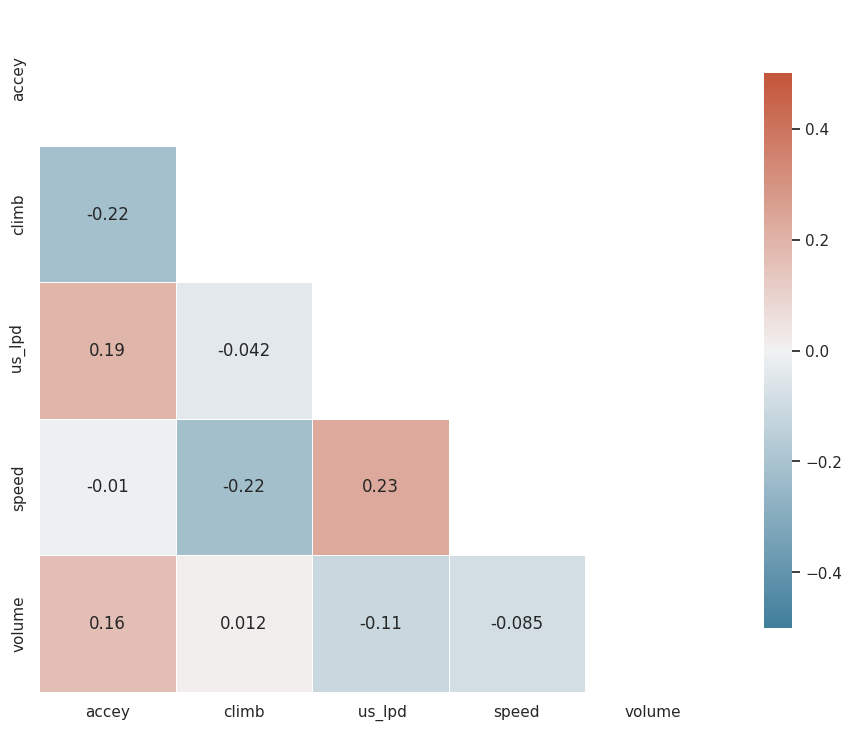

In [ ]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = volume[['accey','climb', ' us_lpd', 'speed', 'volume']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot = True, vmax=.5, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

In [ ]:
for k in range(2,7):
  kmeans=KMeans(n_clusters=k)
  kmeans.fit(volume_t[['climb_t', 'us_lpd_t', 'speed_t', 'volume_t']])
  volume_t[f'KMeans_{k}'] = kmeans.labels_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

Clustering Visualization

In [ ]:
import plotly.express as px
fignew = px.scatter(y=volume_t['latitude'], x=volume_t['longitude'], size=volume_t[' us_lpd'], color=volume_t['KMeans_3'], size_max=25)
fignew.show()

###html converter

In [ ]:
#!pip install nbconvert
#%%shell
!jupyter nbconvert --to html /content/drive/MyDrive/MSc/MSc_Analysis.ipynb
print('Notebook salved in .html file')

[NbConvertApp] Converting notebook /content/drive/MyDrive/MSc/MSc_Analysis.ipynb to html
[NbConvertApp] Writing 2886605 bytes to /content/drive/MyDrive/MSc/MSc_Analysis.html
Notebook salved in .html file
